<a href="https://colab.research.google.com/github/EricLBuehler/Automatic-Differentiation-Custom/blob/main/autodiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Automatic Differentiation

Automatic Differentiation is a core tool used to calculate derivatives which are key to machine learning. This is my personal implementation.

Eric Buehler 2023

In [114]:
# AD
#https://towardsdatascience.com/build-your-own-automatic-differentiation-program-6ecd585eec2a
#https://e-dorigatti.github.io/math/deep%20learning/2020/04/07/autodiff.html
#https://jingnanshi.com/blog/autodiff.html
#https://github.com/karpathy/micrograd
#https://sidsite.com/posts/autodiff/

# Simple NN implementation
#https://mostafa-samir.github.io/auto-diff-pt2/#putting-everything-into-action
#https://stackoverflow.com/questions/67615051/implementing-binary-cross-entropy-loss-gives-different-answer-than-tensorflows

# Softmax derivative
#https://aimatters.wordpress.com/2019/06/17/the-softmax-function-derivative/

# Dataset
#https://raw.githubusercontent.com/johnmyleswhite/ML_for_Hackers/master/02-Exploration/data/01_heights_weights_genders.csv

In [115]:
from abc import ABC, abstractmethod
from typing import *
from functools import reduce
import numpy as np
import copy

Define a base abstract class for all values, and a general OperatorLike class.

In [116]:
class DifferentiableValue(ABC):
    count = 0
    def __init__(self):
        DifferentiableValue.count += 1
        self.id = DifferentiableValue.count 

    @abstractmethod
    def backward(self, var):
        pass

    @abstractmethod
    def forward(self):
        pass

    @abstractmethod
    def __repr__(self) -> str:
        pass

class OperatorLike(ABC):
    pass

General functions

- `generate_topo` topographically sorts a graph, ensuring a directed acyclic graph.

In [117]:
def generate_topo(graph: DifferentiableValue) -> List[DifferentiableValue]:
    topo = []
    visited = set()
    def build_topo(node: DifferentiableValue) -> List[DifferentiableValue]:
        if node not in visited:
            visited.add(node)
            if hasattr(node, "inputs"):
                for input in node.inputs:
                    build_topo(input)
            topo.append(node)
        return topo
    return build_topo(graph)

Define a graph to hold the operations, and a gradient graph to hold gradients.

In [118]:
class GradientGraph:
    def __init__(self, graph: List[DifferentiableValue]):
        self.graph = graph
    
    def wrt(self, var: Union[DifferentiableValue, np.ndarray]) -> np.ndarray:
        if isinstance(var,  np.ndarray):
            array = []
            for item in np.nditer(var.flatten(),["refs_ok"]):
                if item not in self.graph:
                    raise KeyError(f"Variable {var} not found in gradient graph.")
                
                for v in self.graph:
                    if v == item:
                        array.append(v)
            return np.array(array)


        if var not in self.graph:
            raise KeyError(f"Variable {var} not found in gradient graph.")
        for v in self.graph:
            if v == var:
                return v.gradient

    def __repr__(self):
        return "GradientGraph: {}".format(", ".join([str(item) for item in self.graph]))

class Graph:
    def __init__(self):
        self.values = []
        global _graph
        _graph = self
        self.has_backwarded = False
        self.clean_graph = lambda values: (values := values[:-1])

    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        pass

    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        self.clean_graph(self.values)
        return self.values[-1].forward()

    def backward(self) -> np.ndarray:
        self.clean_graph(self.values)
        graph = self.values.copy()
        res = self.values[-1].backward()
        self.values = graph
        self.has_backwarded = True
        return res

    def __repr__(self):
        return "Graph: {}".format(", ".join([str(item) for item in self.values]))

In [119]:
def create_gradient_graph(item) -> GradientGraph:
    filtered = set()
    topo = generate_topo(item)
    for value in topo:
        if not (isinstance(value, OperatorLike) and isinstance(value, Variable)):
            filtered.add(value)
            
    return GradientGraph(list(filtered))

Define constant and variable values.

The `.backward` functions return the derivative of constants and variables.

In [120]:
class Constant(DifferentiableValue):
    count = 0

    def __init__(self, value: Union[SupportsFloat, np.ndarray]):
        super().__init__()
        self.value = value
        Constant.count += 1
        
        self.gradient = 0
        
    def backward(self):
        self.gradient = 0
                
        return _graph
        
    def forward(self) -> Any:
        return self.value

    def __repr__(self) -> str:
        return f"Constant({self.value}, g={self.gradient})"

class Variable(DifferentiableValue):
    count = 0

    def __init__(self, value: Union[SupportsFloat, np.ndarray] = None, name = None):
        super().__init__()
        self._value = value
        self.name = name
        Variable.count += 1
        
        self.gradient = 0
        
    def backward(self):
        self.gradient = 1
                
        return self
    
    @property
    def value(self):
        return self._value
    
    @value.setter
    def value(self, value):
        if self.value == None:
            raise ValueError("Variable does not have value")
        self._value = value
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        if self.value == None:
            raise ValueError("Variable does not have value")
        return self.value

    def __repr__(self) -> str:
        return f"Variable('{self.name}' {self.value}, g={self.gradient})"

Define operation "nodes" that act like values.

The `.backward` functions return the effective value after applying the chain rule, for sums, products, and powers.

Note that the `self.gradient = 1` essentially means that the gradient of y with respect to y is 1 (because `self` is the first element of `reversed(topo`).

See https://jingnanshi.com/blog/autodiff.html for a great explanation.
Note that the equations above table 1 show how the gradients are accumulated, like can be seen in the `_backward` functions.

In [121]:
class Sum(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, left: DifferentiableValue, right:  DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [left, right]
        Sum.count += 1
        
        self.gradient = 0

        def _backward():
            for input in self.inputs:
                input.gradient += self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return sum([input.forward() for input in self.inputs])
    
    def __repr__(self) -> str:
        return "Sum({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Product(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, left: DifferentiableValue, right:  DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [left, right]
        Product.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += self.inputs[1].forward() * self.gradient
            self.inputs[1].gradient += self.inputs[0].forward() * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return reduce((lambda x, y: x * y), [input.forward() for input in self.inputs])

    def __repr__(self) -> str:
        return "Product({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Power(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, base: DifferentiableValue, pow:  DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [base, pow]
        Power.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (self.inputs[1].forward() * self.inputs[0].forward() ** (self.inputs[1] - 1).forward()) * self.gradient
            self.inputs[1].gradient += abs(np.log(self.inputs[0].forward())) * self.inputs[0].forward() ** (self.inputs[1].forward()) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return reduce((lambda x, y: x ** y), [input.forward() for input in self.inputs])

    def __repr__(self) -> str:
        return "Power({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

Trigonometric and other functions

In [122]:
class Sine(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Sine.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += np.cos(self.inputs[0].forward()) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.sin(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Sine({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Cosine(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Cosine.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += -np.sin(self.inputs[0].forward()) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.cos(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Cosine({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Tangent(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Tangent.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (1 / (np.cos(self.inputs[0].forward())**2)) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.tan(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Tangent({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Log(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Sine.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (1 / self.inputs[0].forward()) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.log(abs(self.inputs[0].forward()))

    def __repr__(self) -> str:
        return "Log({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Exp(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Sine.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (np.exp(self.inputs[0].forward())) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.exp(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Log({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

Activation Functions

In [123]:
class ReLU(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        ReLU.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (1 if self.inputs[0].forward() > 0 else 0) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return max(0, self.inputs[0].forward())

    def __repr__(self) -> str:
        return "ReLU({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class LeakyReLU(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue, negative_slope: SupportsFloat = 0.01):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        self.negative_slope = negative_slope
        LeakyReLU.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (1 if self.inputs[0].forward() >= 0 else self.negative_slope) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.array([self.inputs[0].forward() if self.inputs[0].forward() >= 0 else self.inputs[0].forward() * self.negative_slope])

    def __repr__(self) -> str:
        return "LeakyReLU({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Sigmoid(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Sigmoid.count += 1
        
        self.gradient = 0

        def _backward():
            x = self.inputs[0].forward()
            self.inputs[0].gradient += (self.sigmoid(x) * (1-self.sigmoid(x))) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
    
    @staticmethod
    def sigmoid(x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return self.sigmoid(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Sigmoid({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Softmax(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, *inputs: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = inputs
        Softmax.count += 1
        
        self.gradient = 0

        def _backward():
            softmax = self.softmax()
            softmax_vector = softmax.reshape(softmax.shape[0],1)
            softmax_matrix = np.tile(softmax_vector,softmax.shape[0])
            self.inputs[0].gradient += (np.diag(softmax) - (softmax_matrix * np.transpose(softmax_matrix))) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self

    def softmax(self) -> np.ndarray:
        denom = sum([np.exp(input.forward()) for input in self.inputs])
        return np.array([np.exp(input.forward()) / denom for input in self.inputs])
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        denom = sum([np.exp(input.forward()) for input in self.inputs])
        return np.array([np.exp(input.forward()) / denom for input in self.inputs])

    def __repr__(self) -> str:
        return "Softmax({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Abs(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Abs.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += self.inputs[0].forward() * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return abs(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "ReLU({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

Hyperbolic trig functions

In [124]:
class Tanh(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Tanh.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (1 / (np.cosh(self.inputs[0].forward())**2)) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.tanh(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Tanh({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Cosh(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Cosh.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (np.sinh(self.inputs[0].forward())) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.cosh(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Cosh({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Sinh(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Sinh.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (np.cosh(self.inputs[0].forward())) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.cosh(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Sinh({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

Losses

In [125]:
class CrossEntropyLoss:
    def __call__(self, outputs: np.ndarray, targets: np.ndarray):
        log = np.vectorize(lambda x: Log(x))
        term_0 = (-outputs+1) * log(-targets + 1 + 1e-7)
        term_1 = outputs * log(targets + 1e-7)
        res = list((-term_0+term_1).flatten())
        
        return np.sum(res)/len(res)

class MSELoss:
    def __call__(self, outputs: np.ndarray, targets: np.ndarray):
        return np.mean(np.square(targets-outputs))

class MAELoss:
    def __call__(self, outputs: np.ndarray, targets: np.ndarray):
        return np.mean(np.abs(targets-outputs))

np_vectorize = np.vectorize(lambda x : Variable(x))

Define a `generate_operation` function to act as a closure and preform runtime "type replacement" to convert `SupportsFloat` types into `DifferentiableValue`.

In [126]:
def generate_operation(op, self: DifferentiableValue, other: Union[DifferentiableValue, SupportsFloat]):
    if isinstance(other, DifferentiableValue):
        return op(self, other)
    if isinstance(other, (SupportsFloat)):
        return op(self, Constant(other))
    raise TypeError(f"Incompatible type for operation: {type(other)}.")

DifferentiableValue.__add__ = lambda self, other: generate_operation(Sum, self, other)
DifferentiableValue.__sub__ = lambda self, other: self + -other
DifferentiableValue.__neg__ = lambda self: self * -1
DifferentiableValue.__mul__ = lambda self, other: generate_operation(Product, self, other)
DifferentiableValue.__pow__ = lambda self, other: generate_operation(Power, self, other)
DifferentiableValue.__truediv__ = lambda self, other: self * ( (other ** -1) if isinstance(other, np.ndarray) else 1/other)
DifferentiableValue.__abs__ = lambda self: Abs(self)

Test case:

In [127]:
with Graph() as graph:
    x = Variable(0.458, "x")
    y = Sigmoid(Exp(x))
    
print("Raw Graph:")
print(graph.values)
print()

print("Topological Graph:")
topo = generate_topo(y)
for item in topo:
    print(item)
print()

print("Forward value:")
print(graph.forward())
print()
print()

print("Backward graph:")
graph.backward()
print(graph.values)
print()

grad_graph = create_gradient_graph(graph.backward())
print(grad_graph.wrt(x))

del graph

Raw Graph:
[Log(Variable('x' 0.458, g=0), g=0), Sigmoid(Log(Variable('x' 0.458, g=0), g=0), g=0)]

Topological Graph:
Variable('x' 0.458, g=0)
Log(Variable('x' 0.458, g=0), g=0)
Sigmoid(Log(Variable('x' 0.458, g=0), g=0), g=0)

Forward value:
0.829333216455861


Backward graph:
[Log(Variable('x' 0.458, g=0.22376127937065252), g=0.141539632538837), Sigmoid(Log(Variable('x' 0.458, g=0.22376127937065252), g=0.141539632538837), g=1)]

0.6712838381119576


Network and related base classes

In [128]:
class Network:
    def __init__(self, lrate = 1e-4):
        self.attrs = dir(self)
        self.lrate = lrate
        self.layers = []

    def register(self):
        for attr in dir(self):
            if attr not in self.attrs:
                if isinstance(getattr(self, attr), NetworkOperation):
                    self.layers.append(getattr(self, attr))

    def trainable_parameters(self) -> int:
        trainable = 0
        for layer in self.layers:
            trainable += layer.trainable_parameters()
        return trainable
        
    def untrainable_parameters(self) -> int:
        untrainable = 0
        for layer in self.layers:
            untrainable += layer.untrainable_parameters()
        return untrainable

    def backward(self, grads):
        for layer in self.layers:
            layer.backward(grads, self.lrate)

    def __copy__(self):
        cls = self.__class__
        result = cls.__new__(cls)
        result.__dict__.update(self.__dict__)
        return result

    def __deepcopy__(self, memo):
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, copy.deepcopy(v, memo))
        return result

class NetworkOperation(ABC):
    def __init__(self, *vars):
        self.vars = vars

    @abstractmethod
    def trainable_parameters(self) -> int:
        pass

    @abstractmethod
    def untrainable_parameters(self) -> int:
        pass

Layers

In [129]:
class Linear(NetworkOperation):
    def __init__(self, input_features, output_features, has_bias = True):
        self.input_features = input_features
        self.output_features = output_features
        self.weights = np_vectorize(np.random.random((input_features, output_features)))
        self.bias = np_vectorize(np.random.random(output_features)) if has_bias else None
        super().__init__(self.weights)

    def backward(self, grad, lrate):
        grads = grad.wrt(self.weights)
        for i, weight in np.ndenumerate(self.weights):
            weight.value -= lrate * list(grads)[sum(i)].forward()

        if self.bias is not None:
            grads = grad.wrt(self.bias)
            for i, bias in np.ndenumerate(self.bias):
                bias.value -= lrate * list(grads)[sum(i)].forward()

    def trainable_parameters(self) -> int:
        if self.bias is not None:
            return sum(self.weights.shape)+sum(self.bias.shape)
        return sum(self.weights.shape)

    def untrainable_parameters(self) -> int:
        if self.bias is None:
            return self.output_features
        return 0
    
    def __call__(self, x):
        if self.bias is not None:
            return np.add(np.dot(x, self.weights), self.bias)
        return np.dot(x, self.weights)

Custom model

In [130]:
class Model(Network):
    def __init__(self, input_size, mid_size, output_size):
        super().__init__()
        self.inp = Linear(input_size, mid_size)
        self.middle = Linear(mid_size, mid_size)
        self.output = Linear(mid_size, output_size)
        super().register()

    def forward(self, x):
        inp = self.inp(x)
        mid = self.middle(inp)
        return self.output(mid)

Trainable parameters: 61
Untrainable parameters: 0
Total parameters: 61


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


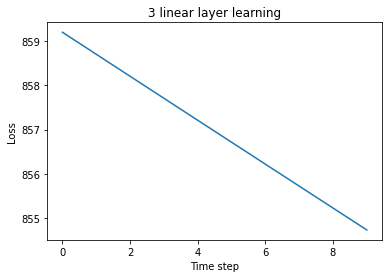

Final loss: 854.7289569751983


In [131]:
import matplotlib.pyplot as plt
import tqdm
np.random.seed(0)

input_size = 5
mid_size = 6
output_size = 10

x = np_vectorize(np.ones(input_size))
y_true = np_vectorize(np.zeros(output_size))#random.random(output_size))

model = Model(input_size, mid_size, output_size)

criterion = MSELoss()

trainable = model.trainable_parameters()
untrainable = model.untrainable_parameters()
print(f"Trainable parameters: {trainable}")
print(f"Untrainable parameters: {untrainable}")
print(f"Total parameters: {trainable + untrainable}")


losses = []
with Graph() as graph:
    for i in tqdm.tqdm(range(10)):
        y_pred = model.forward(x)
        loss = criterion(y_true, y_pred)
        losses.append(loss.forward())

        grad_graph = create_gradient_graph(loss.backward())
        model.backward(grad_graph)

plt.plot(losses)
plt.xlabel("Time step")
plt.ylabel("Loss")
plt.title("3 linear layer learning")
plt.show()

del graph

print("Final loss: "+str(losses[-1]))

In [132]:
raw = model.forward(np_vectorize(np.ones(input_size)))

res = np.vectorize(lambda x: x.forward())(raw)
print(res)
print(np.mean(res))

[34.69099456 23.36052627 31.44509103 27.1408718  29.97128101 37.95359256
 26.78887899 26.5732749  28.30440642 22.45128143]
28.868019895492203


100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


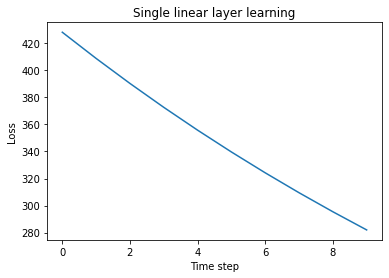

In [133]:
import matplotlib.pyplot as plt
import tqdm
np.random.seed(0)

input_size = 5
output_size = 10
lrate = 0.01

def update_weights(weights, gradients, lrate):
    for i, weight in np.ndenumerate(weights):
        weight.value -= lrate * list(gradients)[sum(i)].forward()

x = np_vectorize(np.random.random(input_size))
y_true = np_vectorize(np.random.random(output_size))
weights = np_vectorize(np.random.random((input_size, output_size)))
weights2 = np_vectorize(np.random.random((output_size, output_size)))

losses = []
with Graph() as graph:
    for i in tqdm.tqdm(range(10)):
        m = np.dot(x, weights)
        y_pred = np.dot(m, weights2)
        loss = np.sum((y_true - y_pred) * (y_true - y_pred))
        losses.append(loss.forward())

        grad_graph = create_gradient_graph(loss.backward())
        update_weights(weights, grad_graph.wrt(weights), lrate)
        update_weights(weights2, grad_graph.wrt(weights2), lrate)

plt.plot(losses)
plt.xlabel("Time step")
plt.ylabel("Loss")
plt.title("Single linear layer learning")
plt.show()


del graph

#Multivariable regression example

In [134]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/auto_diff")

# Load data
data = np.loadtxt('./dataset.csv', delimiter=',', skiprows=1)
x = data[:,0:2]
y = data[:,2]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
print(x)
print(y)



from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

[[ 1.         73.84701702]
 [ 1.         68.78190405]
 [ 1.         74.11010539]
 ...
 [ 0.         63.86799221]
 [ 0.         69.03424313]
 [ 0.         61.94424588]]
[241.8935632 162.3104725 212.7408556 ... 128.4753188 163.8524613
 113.6491027]


In [136]:
class Model(Network):
    def __init__(self, input_size, mid_size):
        super().__init__()
        self.input_size = input_size
        self.mid_size = mid_size
        self.inp = Linear(input_size, mid_size)
        self.mid = Linear(mid_size, mid_size)
        self.out = Linear(mid_size, 1)
        super().register()
        
    def forward(self, x):
        inp = self.inp(x)
        return self.out(self.mid(inp))

Trainable parameters: 40
Untrainable parameters: 0
Total parameters: 40


  1%|          | 10/1500 [00:01<03:00,  8.26it/s]

-1.1113855891152156


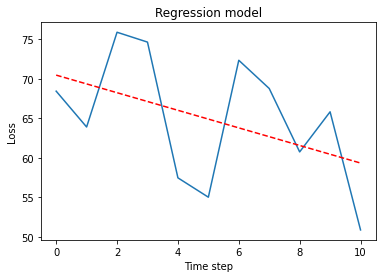

  1%|▏         | 20/1500 [00:02<03:44,  6.59it/s]

-0.9371605962137801


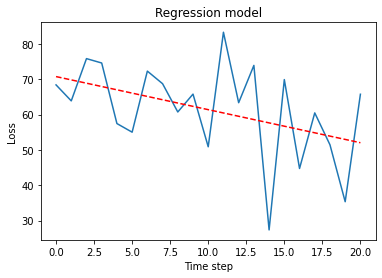

  2%|▏         | 30/1500 [00:05<05:30,  4.45it/s]

-0.5282342534703734


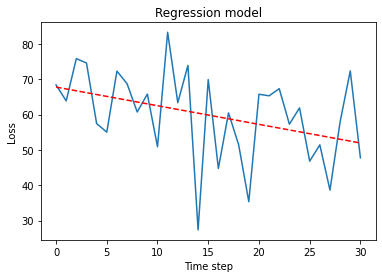

  3%|▎         | 40/1500 [00:07<03:51,  6.31it/s]

-0.3791511259826509


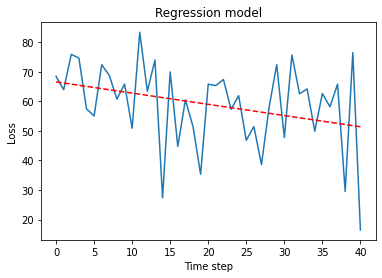

  3%|▎         | 50/1500 [00:09<02:49,  8.54it/s]

-0.31242369678097553


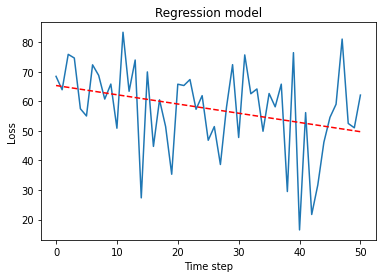

  4%|▍         | 60/1500 [00:10<02:52,  8.36it/s]

-0.13614697893640698


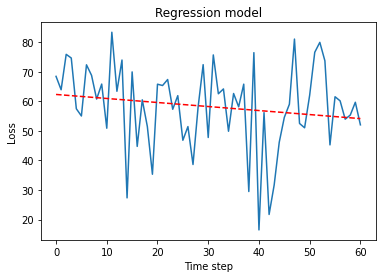

  5%|▍         | 70/1500 [00:11<02:57,  8.06it/s]

-0.20825029051742808


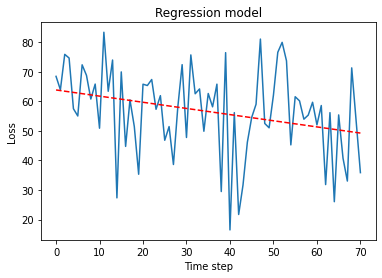

  5%|▌         | 80/1500 [00:13<02:49,  8.38it/s]

-0.1943596319985888


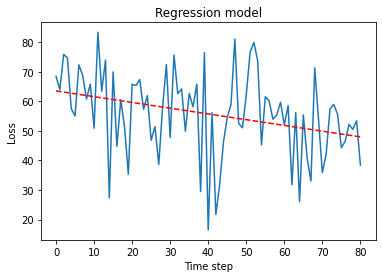

  6%|▌         | 90/1500 [00:14<02:50,  8.28it/s]

-0.15931930216503398


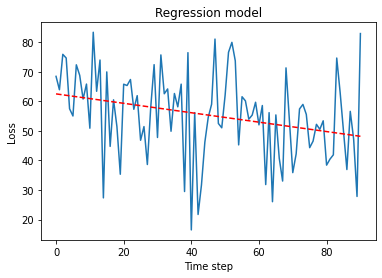

  7%|▋         | 100/1500 [00:16<02:46,  8.43it/s]

-0.14564635310899515


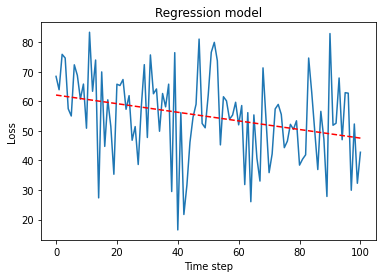

  7%|▋         | 110/1500 [00:17<03:57,  5.85it/s]

-0.14100988239613196


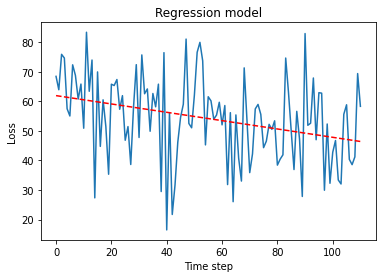

  8%|▊         | 120/1500 [00:20<05:01,  4.58it/s]

-0.1083665827303768


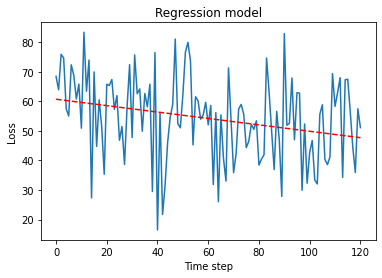

  9%|▊         | 130/1500 [00:22<03:22,  6.78it/s]

-0.11237669924288318


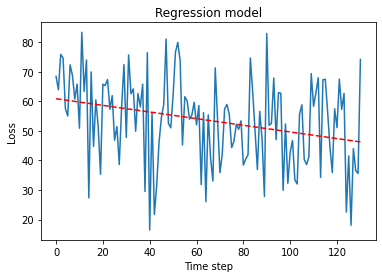

  9%|▉         | 140/1500 [00:23<02:40,  8.48it/s]

-0.0886377155685632


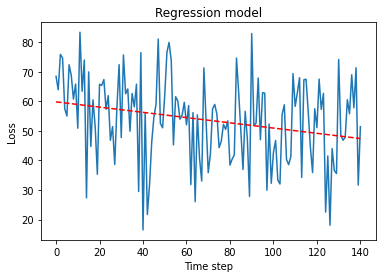

 10%|█         | 150/1500 [00:25<02:49,  7.99it/s]

-0.09564254736436141


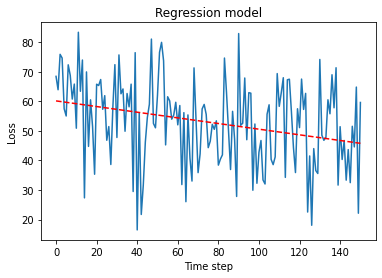

 11%|█         | 160/1500 [00:26<02:45,  8.09it/s]

-0.09506871259524209


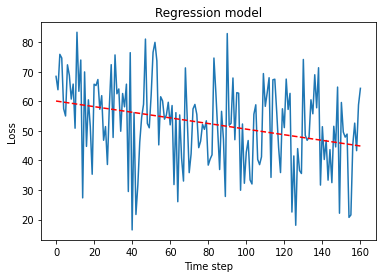

 11%|█▏        | 170/1500 [00:28<02:41,  8.24it/s]

-0.07972597141798424


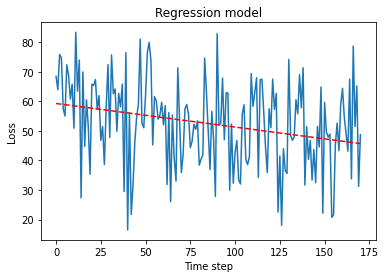

 12%|█▏        | 180/1500 [00:29<02:44,  8.02it/s]

-0.06804883218437385


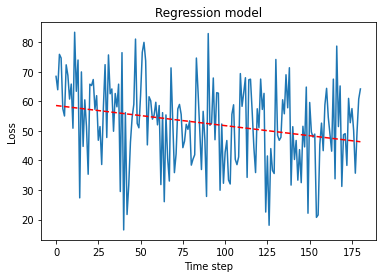

 13%|█▎        | 190/1500 [00:31<02:34,  8.50it/s]

-0.06557219667178486


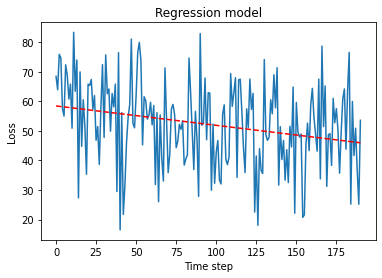

 13%|█▎        | 200/1500 [00:33<04:21,  4.97it/s]

-0.055832594947407194


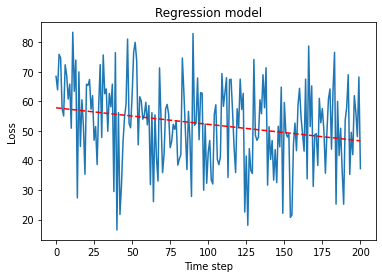

 14%|█▍        | 210/1500 [00:35<04:38,  4.63it/s]

-0.06259657880380554


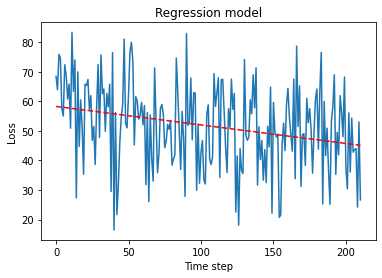

 15%|█▍        | 220/1500 [00:37<03:06,  6.86it/s]

-0.06953461662635345


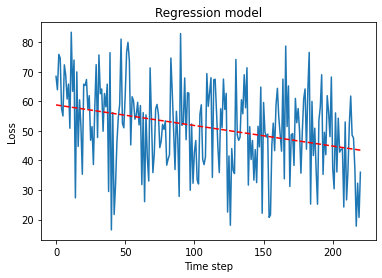

 15%|█▌        | 230/1500 [00:39<02:35,  8.19it/s]

-0.06863998318273055


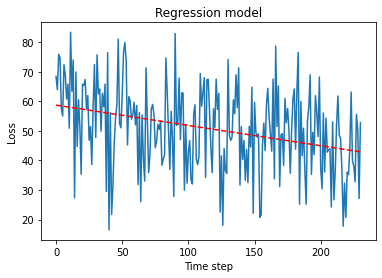

 16%|█▌        | 240/1500 [00:40<02:36,  8.05it/s]

-0.06897879375013544


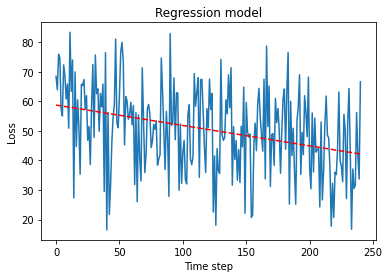

 17%|█▋        | 250/1500 [00:42<02:42,  7.68it/s]

-0.0646757309380575


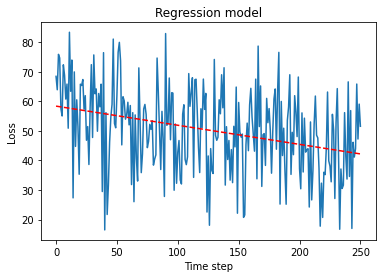

 17%|█▋        | 260/1500 [00:43<02:45,  7.51it/s]

-0.0626285095531506


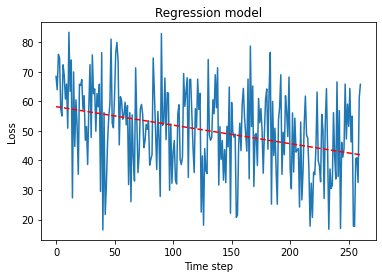

 18%|█▊        | 270/1500 [00:45<02:32,  8.07it/s]

-0.06518654092461403


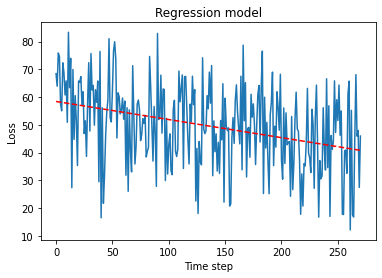

 19%|█▊        | 280/1500 [00:46<02:37,  7.75it/s]

-0.06519282158334448


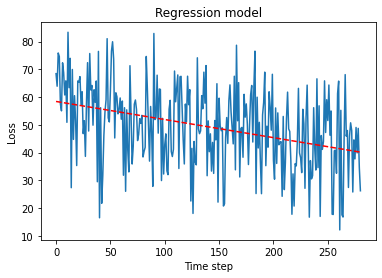

 19%|█▉        | 290/1500 [00:49<04:24,  4.57it/s]

-0.0706502487295517


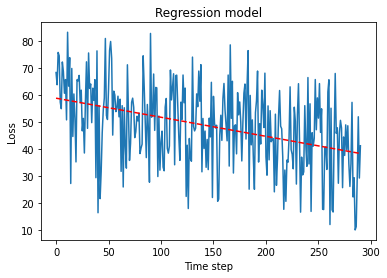

 20%|██        | 300/1500 [00:51<04:30,  4.43it/s]

-0.07208736346561875


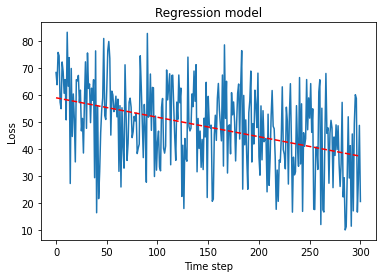

 21%|██        | 310/1500 [00:55<03:03,  6.48it/s]

-0.07189980955641934


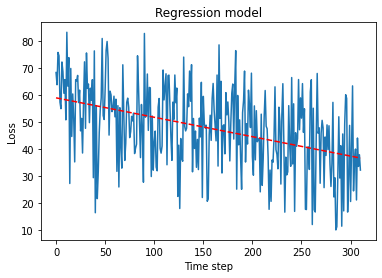

 21%|██▏       | 320/1500 [00:56<02:37,  7.47it/s]

-0.06985646594593384


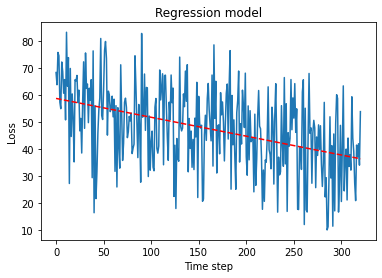

 22%|██▏       | 330/1500 [00:58<02:35,  7.50it/s]

-0.06958664696507805


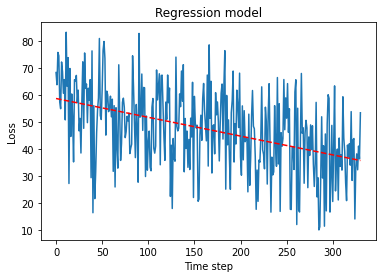

 23%|██▎       | 340/1500 [00:59<02:31,  7.65it/s]

-0.06743886950017851


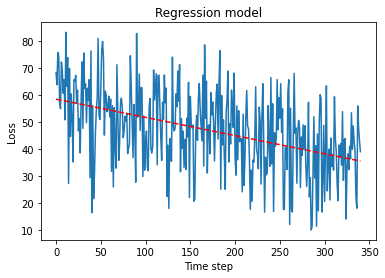

 23%|██▎       | 350/1500 [01:01<02:28,  7.76it/s]

-0.07136359951120858


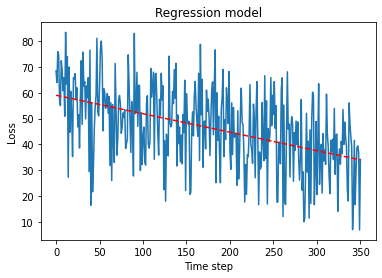

 24%|██▍       | 360/1500 [01:03<04:02,  4.70it/s]

-0.06680011422662745


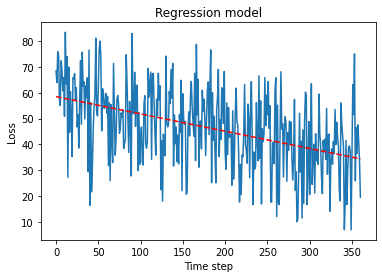

 25%|██▍       | 370/1500 [01:05<04:12,  4.48it/s]

-0.06704864923088524


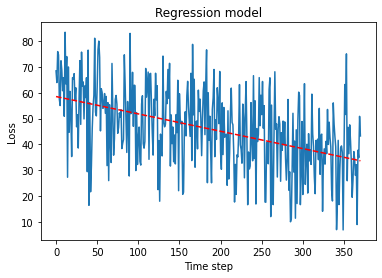

 25%|██▌       | 380/1500 [01:08<02:51,  6.55it/s]

-0.06765108308483754


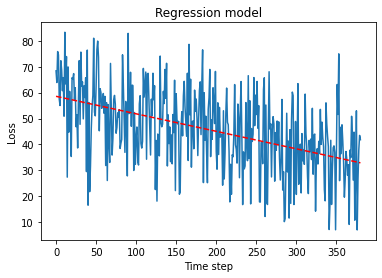

 26%|██▌       | 390/1500 [01:09<02:18,  8.01it/s]

-0.06459305258193108


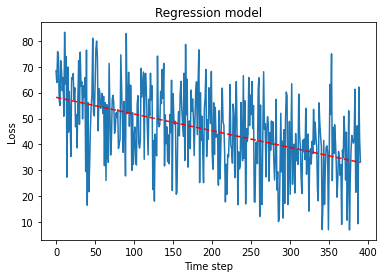

 27%|██▋       | 400/1500 [01:11<04:15,  4.31it/s]

-0.06164643883777048


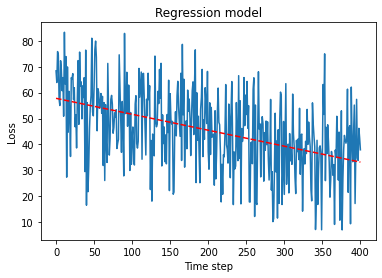

 27%|██▋       | 410/1500 [01:13<02:29,  7.27it/s]

-0.05957017107853392


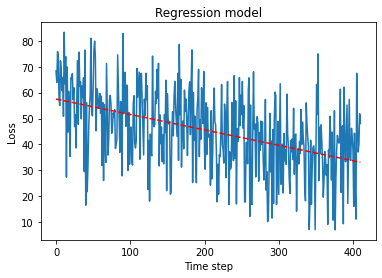

 28%|██▊       | 420/1500 [01:14<02:22,  7.60it/s]

-0.0614115707344593


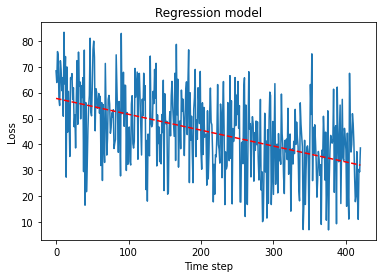

 29%|██▊       | 430/1500 [01:16<02:32,  6.99it/s]

-0.059636653003088624


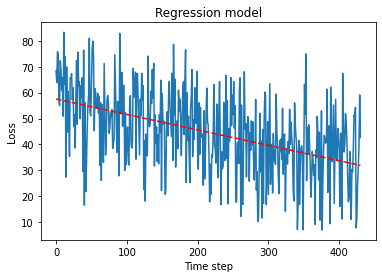

 29%|██▉       | 440/1500 [01:18<03:26,  5.13it/s]

-0.058854270248095135


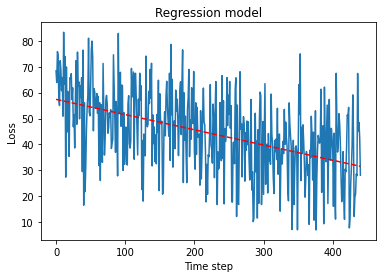

 30%|███       | 450/1500 [01:20<03:59,  4.38it/s]

-0.056544522891036175


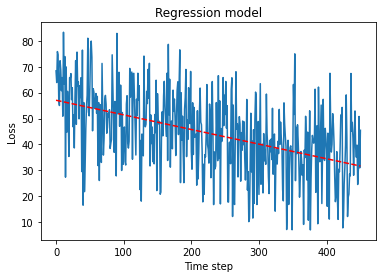

 31%|███       | 460/1500 [01:23<03:12,  5.40it/s]

-0.0571414578151879


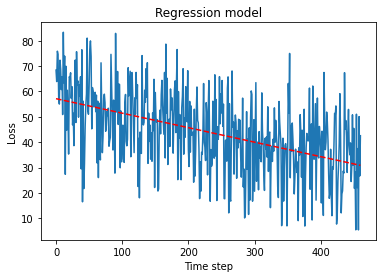

 31%|███▏      | 470/1500 [01:24<02:25,  7.08it/s]

-0.05668240804500979


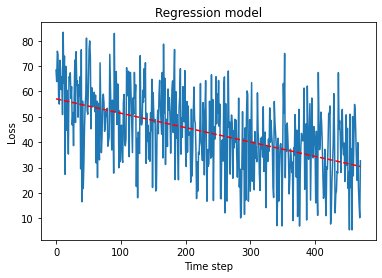

 32%|███▏      | 480/1500 [01:26<02:22,  7.15it/s]

-0.055750200965024


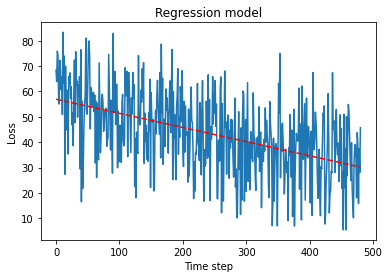

 33%|███▎      | 490/1500 [01:28<02:14,  7.49it/s]

-0.054800341305809123


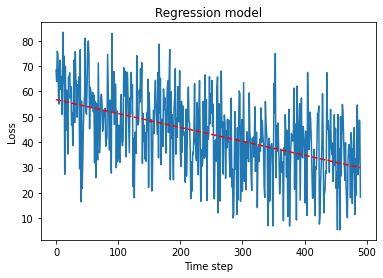

 33%|███▎      | 500/1500 [01:29<02:19,  7.18it/s]

-0.05449733140947242


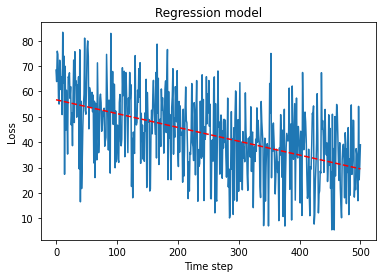

 34%|███▍      | 510/1500 [01:31<02:14,  7.38it/s]

-0.05485638530955755


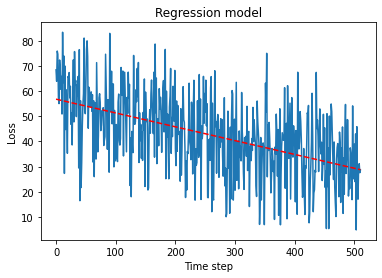

 35%|███▍      | 520/1500 [01:33<03:16,  4.98it/s]

-0.05392443211260458


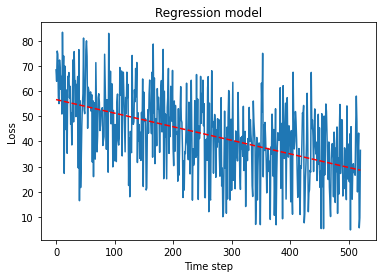

 35%|███▌      | 530/1500 [01:36<03:23,  4.76it/s]

-0.05392411222252979


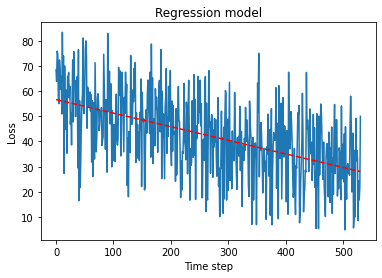

 36%|███▌      | 540/1500 [01:39<03:54,  4.10it/s]

-0.05195104628093999


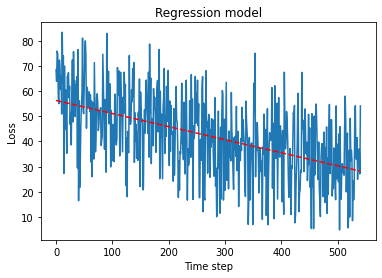

 37%|███▋      | 550/1500 [01:40<02:12,  7.18it/s]

-0.05244543130549884


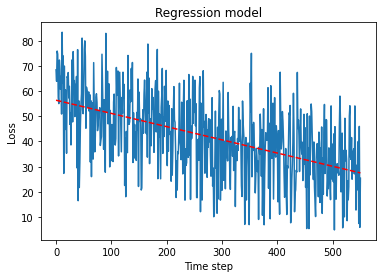

 37%|███▋      | 560/1500 [01:42<02:08,  7.31it/s]

-0.0520983070570586


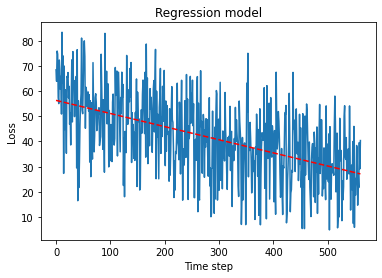

 38%|███▊      | 570/1500 [01:43<02:09,  7.16it/s]

-0.051190810317370876


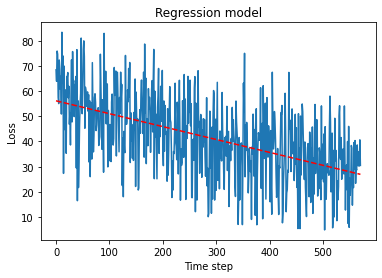

 39%|███▊      | 580/1500 [01:45<02:06,  7.29it/s]

-0.05123086001735933


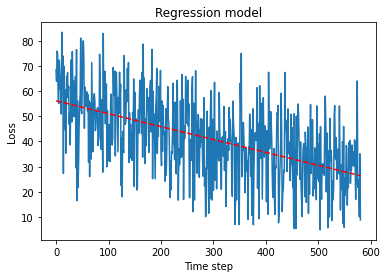

 39%|███▉      | 590/1500 [01:47<02:02,  7.43it/s]

-0.05095646595123955


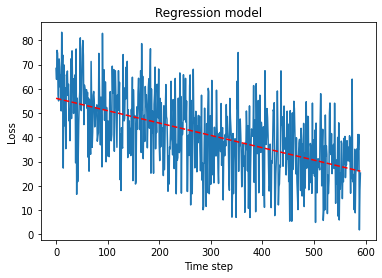

 40%|████      | 600/1500 [01:48<02:14,  6.69it/s]

-0.05093966361007367


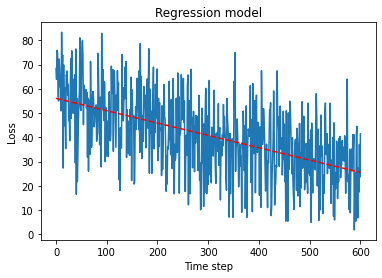

 41%|████      | 610/1500 [01:51<03:08,  4.72it/s]

-0.050290787442350035


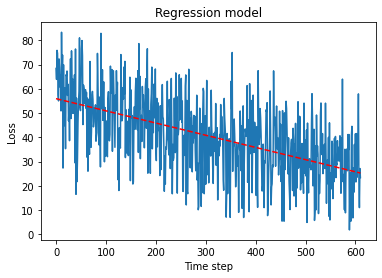

 41%|████▏     | 620/1500 [01:53<03:20,  4.39it/s]

-0.049272357455425124


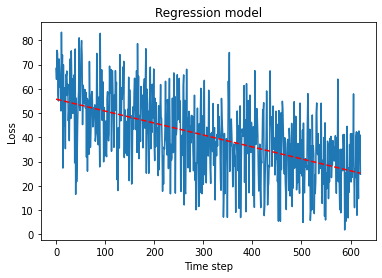

 42%|████▏     | 630/1500 [01:55<02:03,  7.03it/s]

-0.04903287781844095


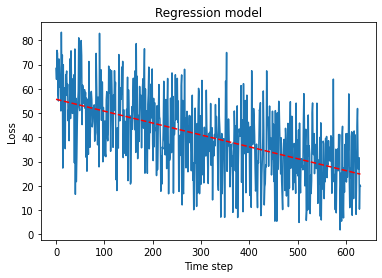

 43%|████▎     | 640/1500 [01:57<02:00,  7.16it/s]

-0.048905031368716795


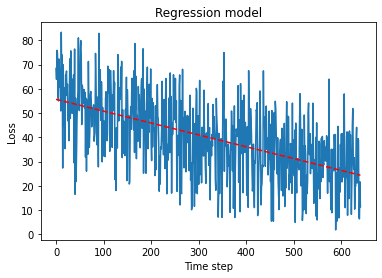

 43%|████▎     | 650/1500 [01:59<02:00,  7.03it/s]

-0.04845192467898821


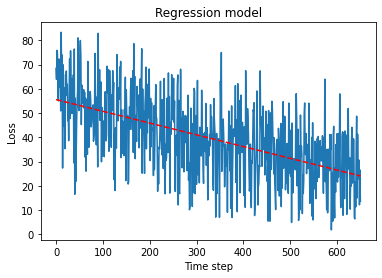

 44%|████▍     | 660/1500 [02:01<02:26,  5.75it/s]

-0.0482144029466421


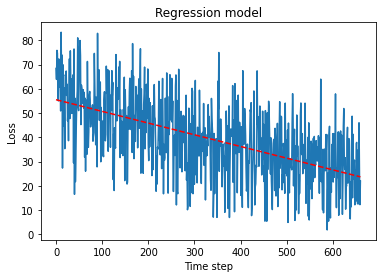

 45%|████▍     | 670/1500 [02:02<02:02,  6.79it/s]

-0.04820832701840645


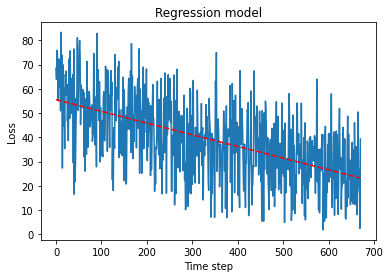

 45%|████▌     | 680/1500 [02:04<02:06,  6.50it/s]

-0.04845110774114963


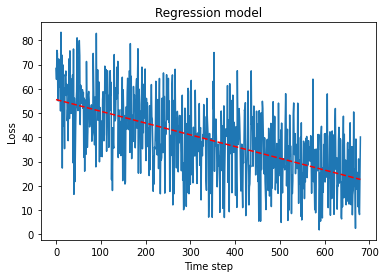

 46%|████▌     | 690/1500 [02:07<02:48,  4.80it/s]

-0.04732984067879659


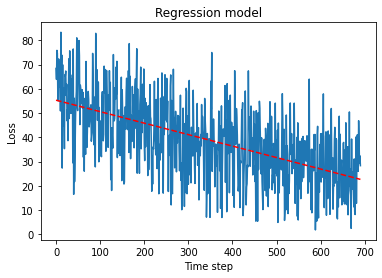

 47%|████▋     | 700/1500 [02:09<02:54,  4.58it/s]

-0.04675533495671022


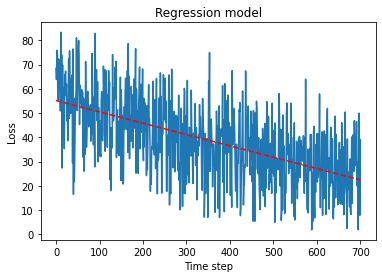

 47%|████▋     | 710/1500 [02:11<02:07,  6.19it/s]

-0.04619194988453952


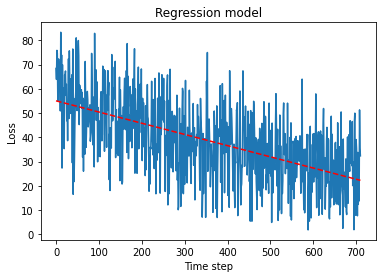

 48%|████▊     | 720/1500 [02:13<01:49,  7.13it/s]

-0.04550022503312756


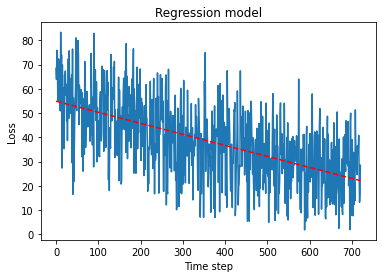

 49%|████▊     | 730/1500 [02:15<01:50,  6.96it/s]

-0.04471774524727734


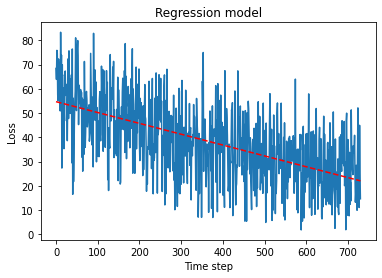

 49%|████▉     | 740/1500 [02:16<01:53,  6.69it/s]

-0.044623639500141386


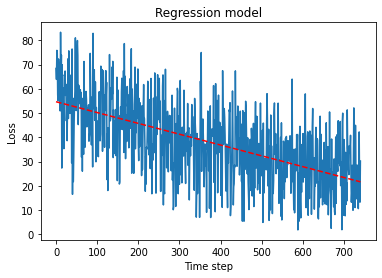

 50%|█████     | 750/1500 [02:18<01:45,  7.10it/s]

-0.04420653782459477


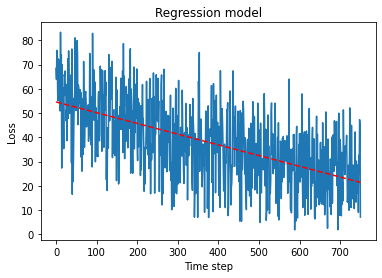

 51%|█████     | 760/1500 [02:20<01:47,  6.87it/s]

-0.04401182853341218


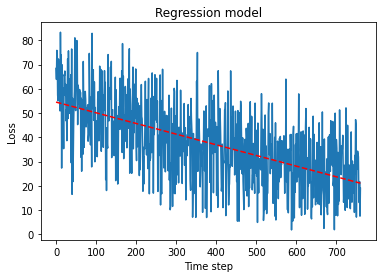

 51%|█████▏    | 770/1500 [02:22<02:36,  4.68it/s]

-0.04321035813879112


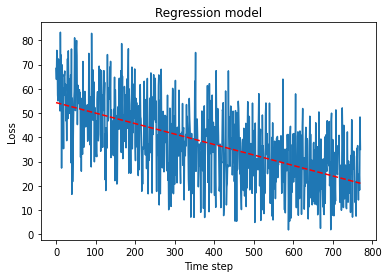

 52%|█████▏    | 780/1500 [02:25<02:35,  4.64it/s]

-0.04285663776950632


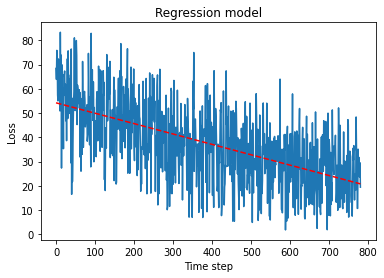

 53%|█████▎    | 790/1500 [02:27<02:29,  4.75it/s]

-0.042206182803238367


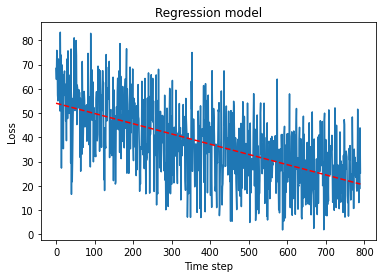

 53%|█████▎    | 800/1500 [02:29<01:42,  6.84it/s]

-0.04174382690732743


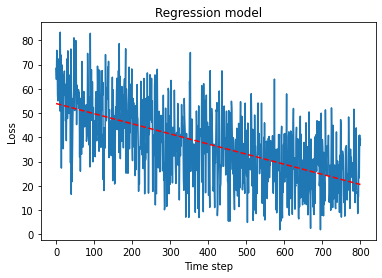

 54%|█████▍    | 810/1500 [02:31<01:36,  7.18it/s]

-0.04142630392751848


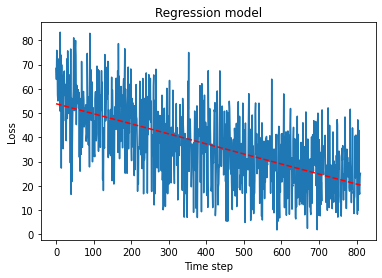

 55%|█████▍    | 820/1500 [02:32<01:38,  6.87it/s]

-0.040741347241648865


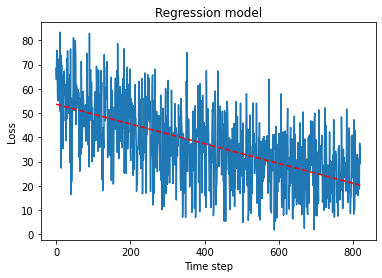

 55%|█████▌    | 830/1500 [02:35<01:44,  6.40it/s]

-0.040047681938123206


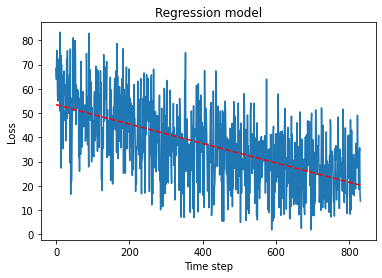

 56%|█████▌    | 840/1500 [02:37<02:19,  4.72it/s]

-0.03972636029389411


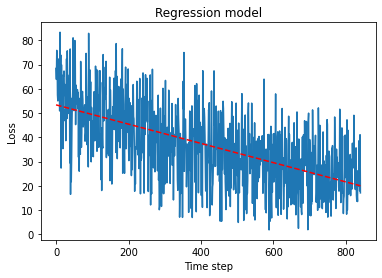

 57%|█████▋    | 850/1500 [02:40<02:25,  4.45it/s]

-0.03948221959570867


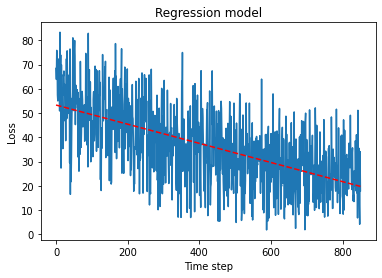

 57%|█████▋    | 860/1500 [02:42<02:20,  4.56it/s]

-0.03963592543193958


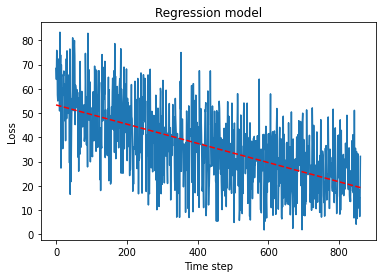

 58%|█████▊    | 870/1500 [02:45<01:36,  6.50it/s]

-0.038708086273216064


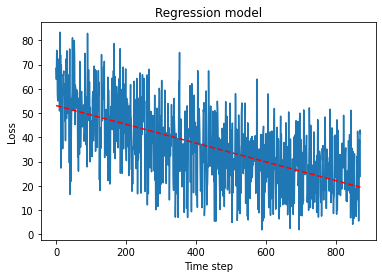

 59%|█████▊    | 880/1500 [02:46<01:30,  6.86it/s]

-0.03835137037370442


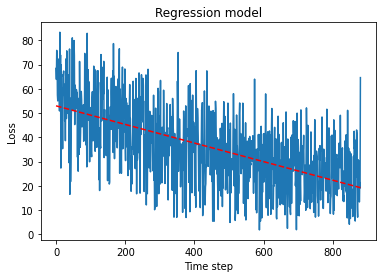

 59%|█████▉    | 890/1500 [02:48<01:35,  6.37it/s]

-0.03753674436563745


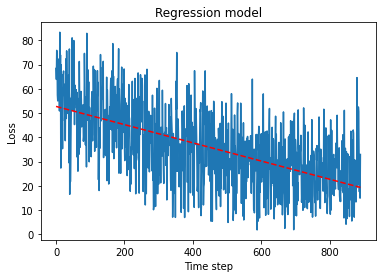

 60%|██████    | 900/1500 [02:50<01:29,  6.67it/s]

-0.03688780264986196


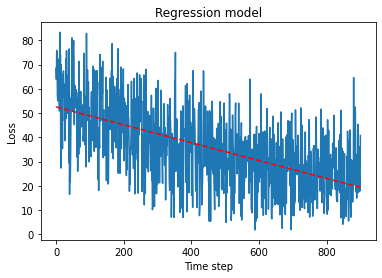

 61%|██████    | 910/1500 [02:52<01:25,  6.94it/s]

-0.03637143054854244


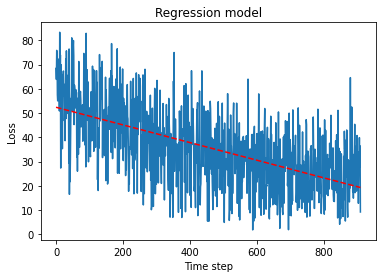

 61%|██████▏   | 920/1500 [02:53<01:24,  6.86it/s]

-0.03556211128778089


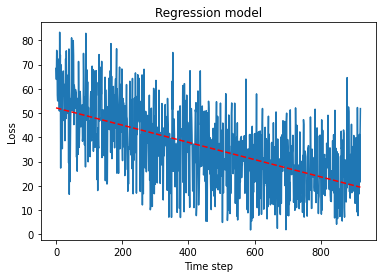

 62%|██████▏   | 930/1500 [02:56<02:12,  4.31it/s]

-0.035155983200725105


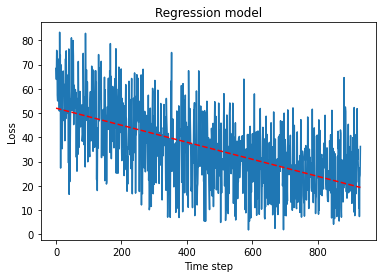

 63%|██████▎   | 940/1500 [02:58<02:05,  4.46it/s]

-0.03460426015371149


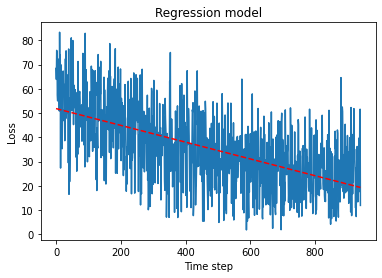

 63%|██████▎   | 950/1500 [03:01<01:44,  5.25it/s]

-0.03390301450678359


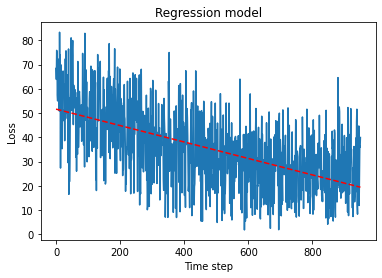

 64%|██████▍   | 960/1500 [03:03<01:24,  6.37it/s]

-0.03356199375126145


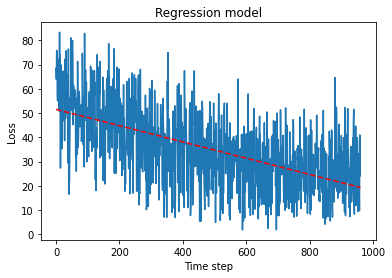

 65%|██████▍   | 970/1500 [03:04<01:19,  6.70it/s]

-0.0331689625592924


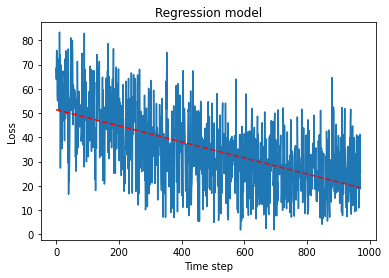

 65%|██████▌   | 980/1500 [03:06<01:18,  6.62it/s]

-0.03294656265268265


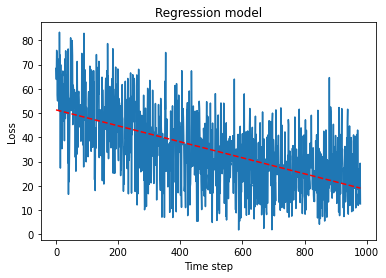

 66%|██████▌   | 990/1500 [03:08<01:16,  6.65it/s]

-0.032264509538232275


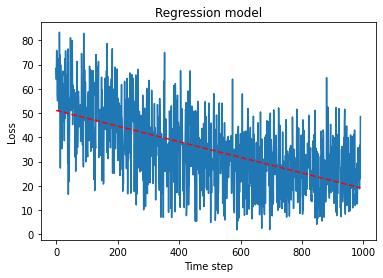

 67%|██████▋   | 1000/1500 [03:10<01:10,  7.10it/s]

-0.03224187100691772


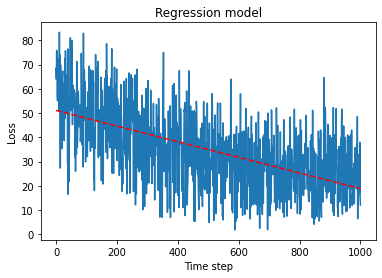

 67%|██████▋   | 1010/1500 [03:12<01:48,  4.50it/s]

-0.03172182719342229


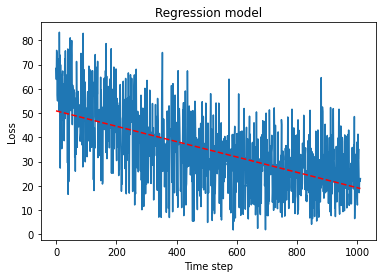

 68%|██████▊   | 1020/1500 [03:15<01:51,  4.32it/s]

-0.03138220420652789


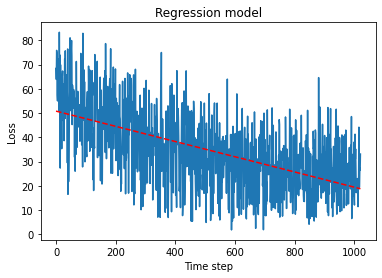

 69%|██████▊   | 1030/1500 [03:18<01:52,  4.18it/s]

-0.031229045115011678


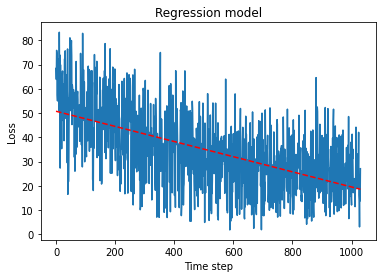

 69%|██████▉   | 1040/1500 [03:19<01:12,  6.39it/s]

-0.03097449503285232


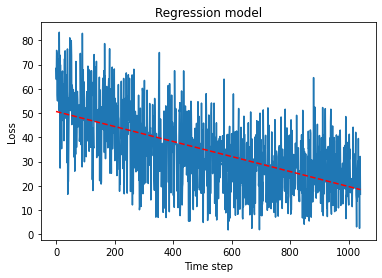

 70%|███████   | 1050/1500 [03:21<01:08,  6.62it/s]

-0.030496241207562415


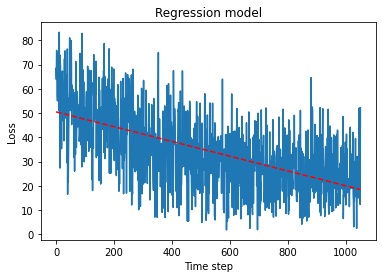

 71%|███████   | 1060/1500 [03:23<01:06,  6.62it/s]

-0.030353086409423552


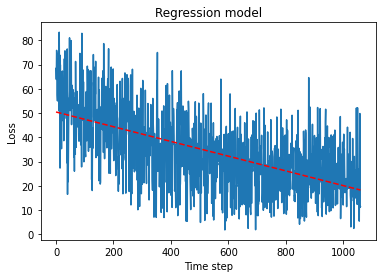

 71%|███████▏  | 1070/1500 [03:25<01:04,  6.68it/s]

-0.030296012357576504


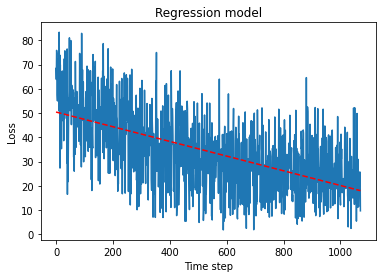

 72%|███████▏  | 1080/1500 [03:27<01:09,  6.02it/s]

-0.029953891398132117


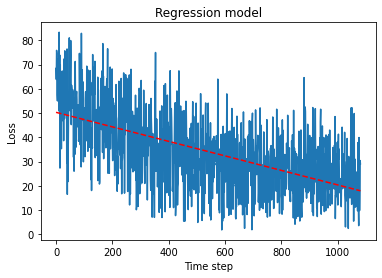

 73%|███████▎  | 1090/1500 [03:29<01:23,  4.90it/s]

-0.029706094294295316


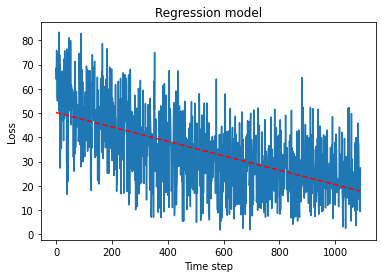

 73%|███████▎  | 1100/1500 [03:32<01:29,  4.46it/s]

-0.029673054365282538


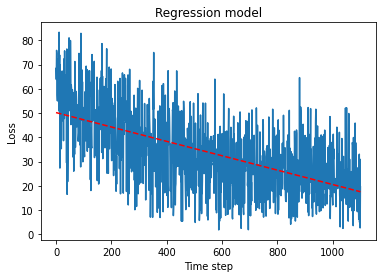

 74%|███████▍  | 1110/1500 [03:34<01:08,  5.74it/s]

-0.029442172710987508


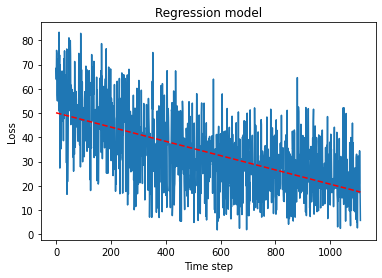

 75%|███████▍  | 1120/1500 [03:36<00:57,  6.66it/s]

-0.029432883594272295


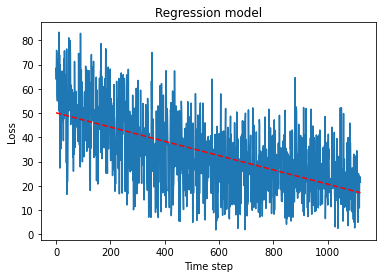

 75%|███████▌  | 1130/1500 [03:38<00:54,  6.75it/s]

-0.02916869230141175


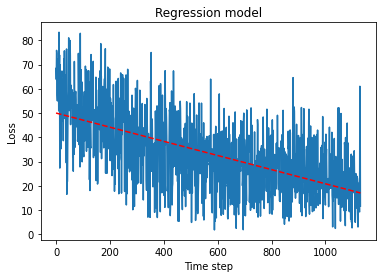

 76%|███████▌  | 1140/1500 [03:40<00:58,  6.19it/s]

-0.028926625066887143


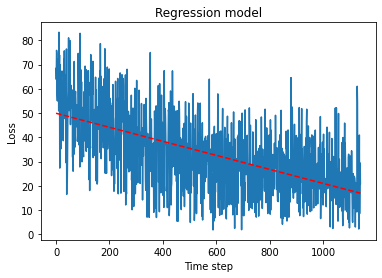

 77%|███████▋  | 1150/1500 [03:41<00:53,  6.57it/s]

-0.028687647279352812


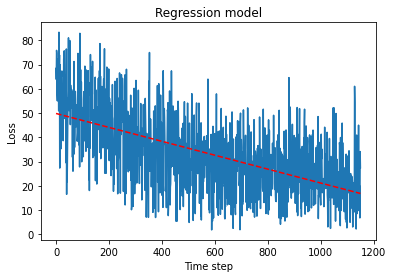

 77%|███████▋  | 1160/1500 [03:43<00:52,  6.42it/s]

-0.028339161855570165


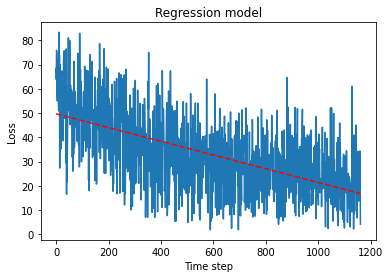

 78%|███████▊  | 1170/1500 [03:46<01:15,  4.38it/s]

-0.02797687462760444


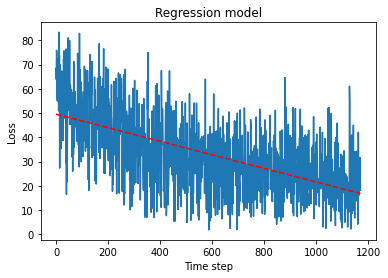

 79%|███████▊  | 1180/1500 [03:48<01:09,  4.62it/s]

-0.02795450184954296


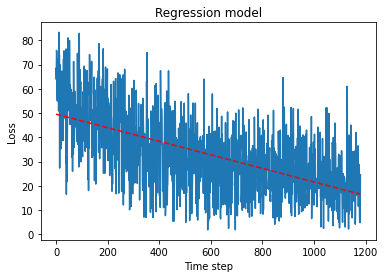

 79%|███████▉  | 1190/1500 [03:51<00:58,  5.30it/s]

-0.02743449835460072


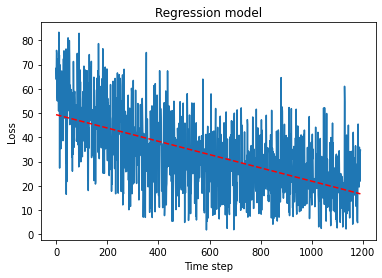

 80%|████████  | 1200/1500 [03:53<00:45,  6.55it/s]

-0.02708963705998629


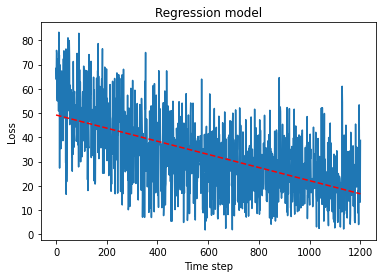

 81%|████████  | 1210/1500 [03:54<00:45,  6.39it/s]

-0.027031999570391093


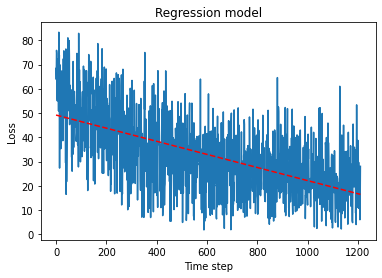

 81%|████████▏ | 1220/1500 [03:56<00:43,  6.38it/s]

-0.026495993615787795


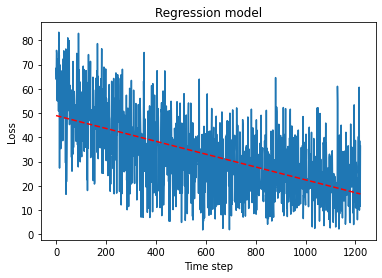

 82%|████████▏ | 1230/1500 [03:58<00:42,  6.29it/s]

-0.025714396922561607


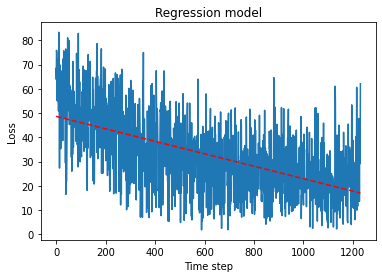

 83%|████████▎ | 1240/1500 [04:00<00:42,  6.19it/s]

-0.02537115342620288


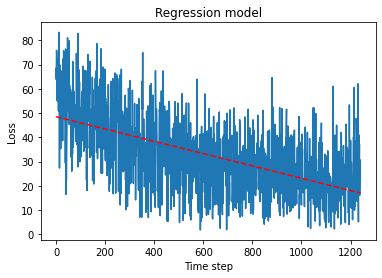

 83%|████████▎ | 1250/1500 [04:03<00:53,  4.65it/s]

-0.025156009654229945


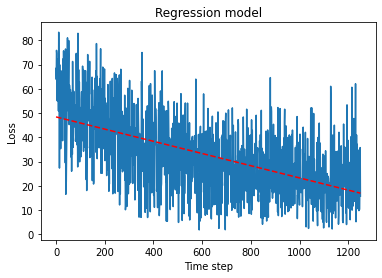

 84%|████████▍ | 1260/1500 [04:05<00:52,  4.54it/s]

-0.024967381464941037


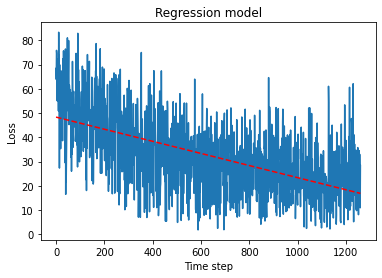

 85%|████████▍ | 1270/1500 [04:08<00:51,  4.51it/s]

-0.024701931479957476


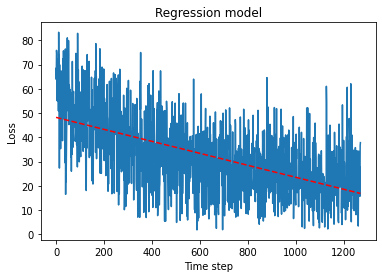

 85%|████████▌ | 1280/1500 [04:10<00:51,  4.24it/s]

-0.024272522502835143


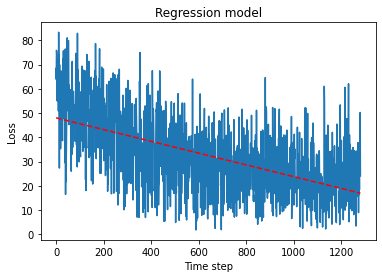

 86%|████████▌ | 1290/1500 [04:12<00:33,  6.31it/s]

-0.023900888964435936


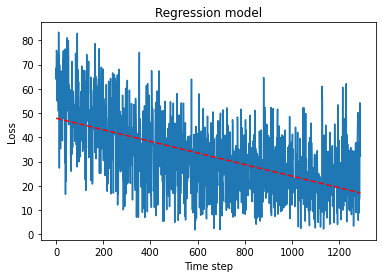

 87%|████████▋ | 1300/1500 [04:14<00:31,  6.30it/s]

-0.023322270715285705


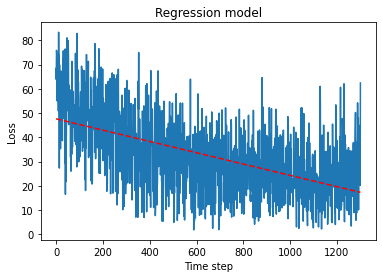

 87%|████████▋ | 1310/1500 [04:16<00:30,  6.31it/s]

-0.02289605359232006


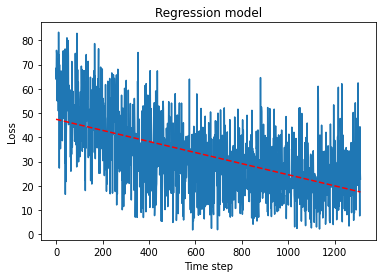

 88%|████████▊ | 1320/1500 [04:18<00:28,  6.29it/s]

-0.02252204328395286


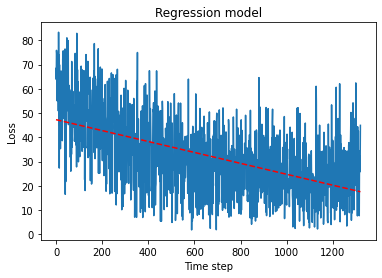

 89%|████████▊ | 1330/1500 [04:20<00:39,  4.35it/s]

-0.0221036153674212


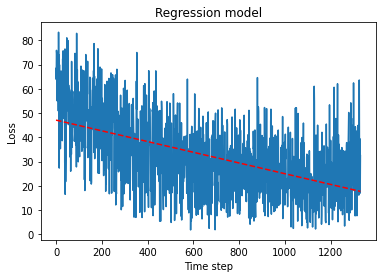

 89%|████████▉ | 1340/1500 [04:23<00:39,  4.06it/s]

-0.02189777735265692


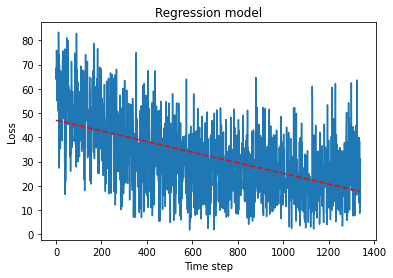

 90%|█████████ | 1350/1500 [04:25<00:26,  5.59it/s]

-0.021464622979414635


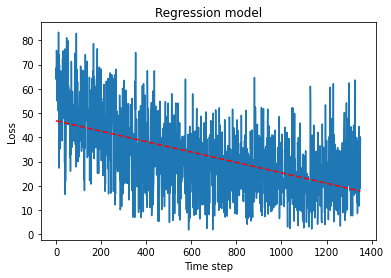

 91%|█████████ | 1360/1500 [04:27<00:21,  6.49it/s]

-0.0213807027824795


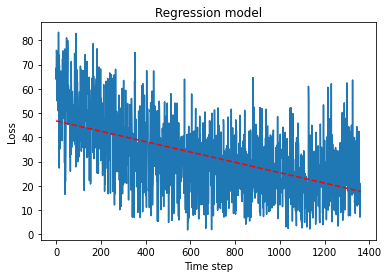

 91%|█████████▏| 1370/1500 [04:29<00:20,  6.43it/s]

-0.020985099089878397


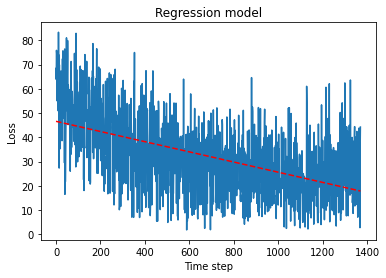

 92%|█████████▏| 1380/1500 [04:31<00:19,  6.19it/s]

-0.020827329703357877


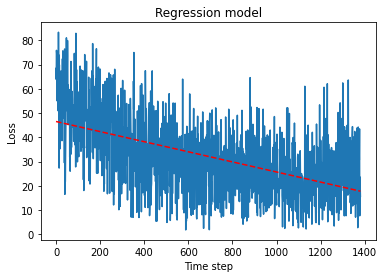

 93%|█████████▎| 1390/1500 [04:33<00:17,  6.26it/s]

-0.020684752532864798


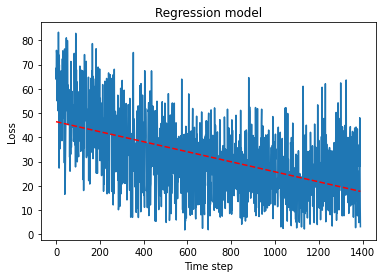

 93%|█████████▎| 1400/1500 [04:35<00:15,  6.42it/s]

-0.020420729992655578


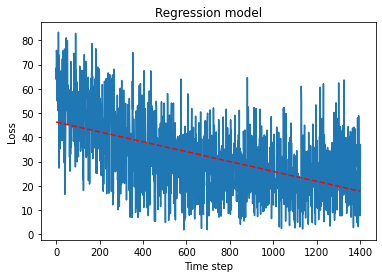

 94%|█████████▍| 1410/1500 [04:37<00:20,  4.48it/s]

-0.020090514505287486


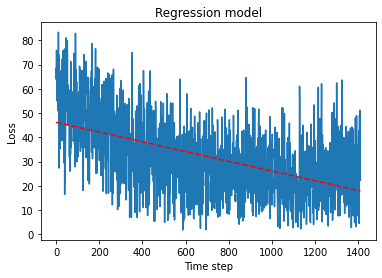

 95%|█████████▍| 1420/1500 [04:40<00:19,  4.15it/s]

-0.019642282340708823


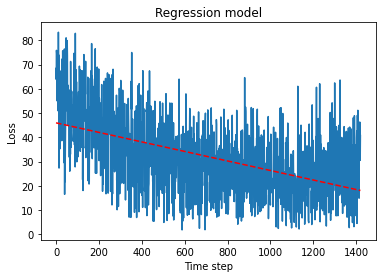

 95%|█████████▌| 1430/1500 [04:43<00:14,  4.77it/s]

-0.019426241561797005


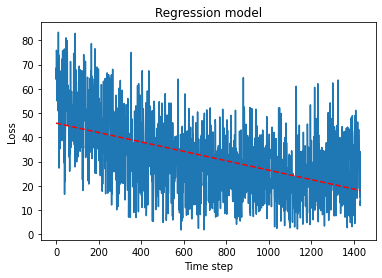

 96%|█████████▌| 1440/1500 [04:44<00:09,  6.27it/s]

-0.01910325826751098


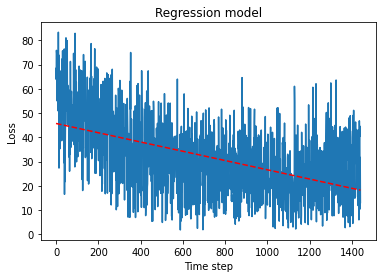

 97%|█████████▋| 1450/1500 [04:46<00:08,  6.12it/s]

-0.018876894562286715


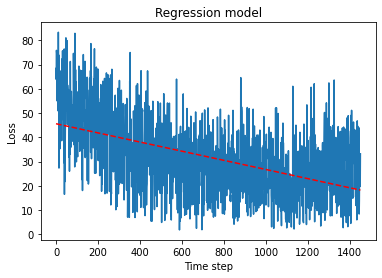

 97%|█████████▋| 1460/1500 [04:48<00:06,  6.33it/s]

-0.01860977647619062


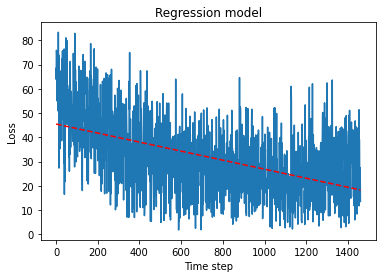

 98%|█████████▊| 1470/1500 [04:50<00:04,  6.16it/s]

-0.018335302131745078


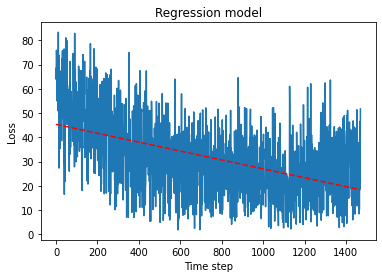

 99%|█████████▊| 1480/1500 [04:52<00:03,  6.20it/s]

-0.018096203214305353


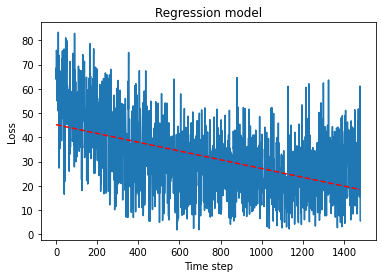

 99%|█████████▉| 1490/1500 [04:55<00:02,  4.77it/s]

-0.017427063856878575


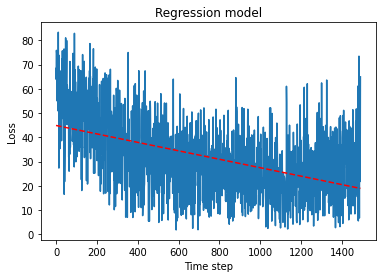

100%|██████████| 1500/1500 [04:57<00:00,  5.04it/s]


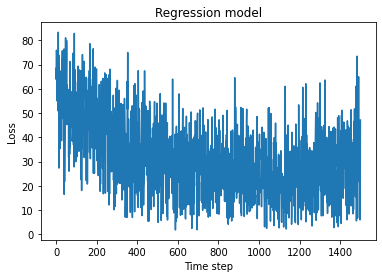

Final loss: 47.1569621


In [141]:
import matplotlib.pyplot as plt
import tqdm

np.random.seed(0)

input_size = x_train.shape[1]
mid_size = 6

x_train_mod = np_vectorize(x_train)
y_train_mod = np_vectorize(y_train)
model = Model(input_size, mid_size)
model.lrate = 1e-4

criterion = MAELoss()

trainable = model.trainable_parameters()
untrainable = model.untrainable_parameters()
print(f"Trainable parameters: {trainable}")
print(f"Untrainable parameters: {untrainable}")
print(f"Total parameters: {trainable + untrainable}")

min = None
minloss = 1e100

view_base = 0

losses = []
with Graph() as graph:
    for i in tqdm.tqdm(range(1500)):
            n = 2
            data = x_train_mod[view_base:(i+1)*n, :]
            y_train_mod2 = y_train_mod[view_base:(i+1)*n]
            view_base = (i+1)*n
            
            y_pred = model.forward(data)
            loss = criterion(y_train_mod2, y_pred)
            
            losses.append(loss.forward())

            grad_graph = create_gradient_graph(loss.backward())
            model.backward(grad_graph)

            if losses[-1] < minloss:
                min = (i, copy.deepcopy(model))
                minloss = losses[-1]

            if i % 10 == 0 and len(losses) > 1:
                plt.plot(losses)

                slope, intercept = np.polyfit(list(range(len(losses))), losses, 1)
                print(slope)
                if slope > 0 and i>100:
                    break
                T_min, T_max = 0, len(losses)-1
                a_min, a_max = intercept + slope*T_min, intercept + slope*T_max
                plt.plot([T_min, T_max], [a_min, a_max], 'r--')

                plt.xlabel("Time step")
                plt.ylabel("Loss")
                plt.title("Regression model")
                plt.show()
    
del graph

plt.plot(losses)
plt.xlabel("Time step")
plt.ylabel("Loss")
plt.title("Regression model")
plt.show()


print("Final loss: "+str(losses[-1]))

In [144]:
print(losses[-1])
print(model.forward(np.array([Variable(1), Variable(73)]))[0].forward())
print(min)
print(min[1].forward(np.array([Variable(1), Variable(73)]))[0].forward())
print(minloss)

47.1569621
152.21482856262276
(588, <__main__.Model object at 0x7fed5b6352b0>)
201.36261692467573
1.8205760849440367


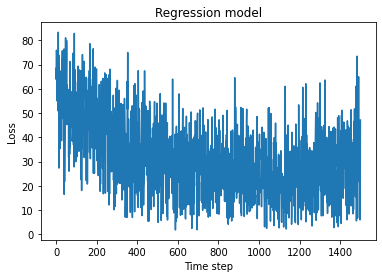

In [145]:
plt.plot(losses)
plt.xlabel("Time step")
plt.ylabel("Loss")
plt.title("Regression model")
plt.show()